In [12]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Dimensions of the bipolar image: (510, 510)


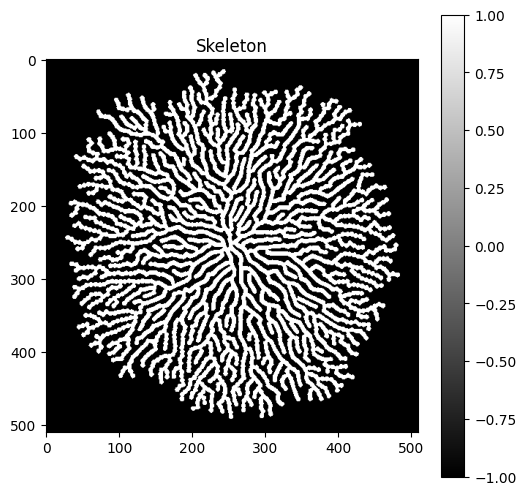

In [13]:
import numpy as np
import matplotlib.image as mpimg

# Step 1: Load the RGB image
image_path = "D:\\Fungateria\\Code\\Mycelium_Ver_2\\Fitting\\Mycelium_model_real_image.png"
rgb_image = mpimg.imread(image_path)

# Step 2: Use only the first channel for simplicity
first_channel = rgb_image[:, :, 0]  # Extract the first channel
threshold = 0.5
skeleton = np.where(first_channel < threshold, 1, -1)  # Create bipolar image directly

# Step 3: Extract dimensions
dimensions = skeleton.shape
print(f"Dimensions of the bipolar image: {dimensions}")

# Step 4: Plot the bipolar image
plt.figure(figsize=(6, 6))
plt.title('Skeleton')
plt.imshow(skeleton, cmap='gray')
plt.colorbar()
plt.show()


In [14]:
# Hyperparameters
grid_size = skeleton.shape[0]
total_iterations = 1000

In [15]:
# Reaction-Diffusion parameters
pa = 0.5
pb = 0.8
pc = 0.16
pe = 2.6
d = 30
dt = 1e-1
threshold = 0.5
pk = 0.05
gamma = 625
ph = 1
alpha = 1
amax = 100
smax = 35
substrate_val = 0.3

255
(510, 510)
torch.Size([510, 510])
torch.Size([510, 510])
torch.Size([510, 510])


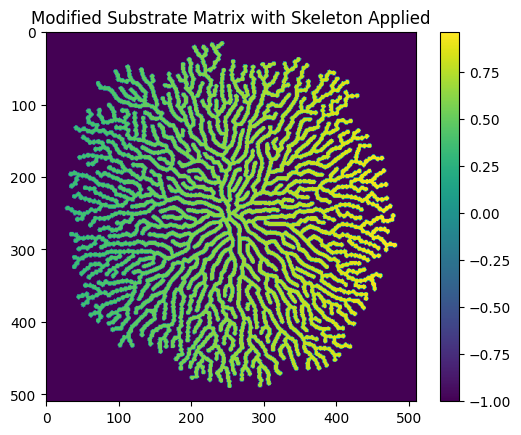

In [16]:
# Initialize activator, suppressor, and mycelium matrices as PyTorch tensors
u = torch.zeros((grid_size, grid_size), device=device)
v = torch.zeros((grid_size, grid_size), device=device)
c = torch.zeros((grid_size, grid_size), device=device)

u_new = torch.zeros_like(u)
v_new = torch.zeros_like(v)
c_new = torch.zeros_like(c)

# Initialize nutrient landscape
mid = grid_size // 2

n = np.linspace(substrate_val, 1, grid_size)
n = np.tile(n, (grid_size, 1))

# Step 2: Apply the skeleton mask
n[skeleton < 0] = -1
print(mid)

print(n.shape)
print(u.shape)
print(v.shape)
print(c.shape)

plt.imshow(n, cmap='viridis')  # Using viridis for better color distinction
plt.colorbar()
plt.title("Modified Substrate Matrix with Skeleton Applied")
plt.show()

n = torch.tensor(n, dtype=torch.float32, device=device)

In [17]:
# Initialize matrices
u = torch.zeros((grid_size, grid_size), device=device)
v = torch.zeros((grid_size, grid_size), device=device)
c = torch.zeros((grid_size, grid_size), device=device)

# Initial activator and suppressor states
for k in range(-5, 6):  # This ranges from -5 to 5, inclusive
    size = 2 * abs(k) + 1  # This computes the size of the square
    start_idx = mid + k if k < 0 else mid - k
    if start_idx + size <= grid_size:  # Check to ensure indices are within bounds
        random_tensor = torch.rand((size, size), device=device) * 0.5 
        u[start_idx:start_idx+size, start_idx:start_idx+size] = 0.5 - 2 * random_tensor 
        v[start_idx:start_idx+size, start_idx:start_idx+size] = 0.1 - 2 * random_tensor 
        c[start_idx:start_idx+size, start_idx:start_idx+size] = 1

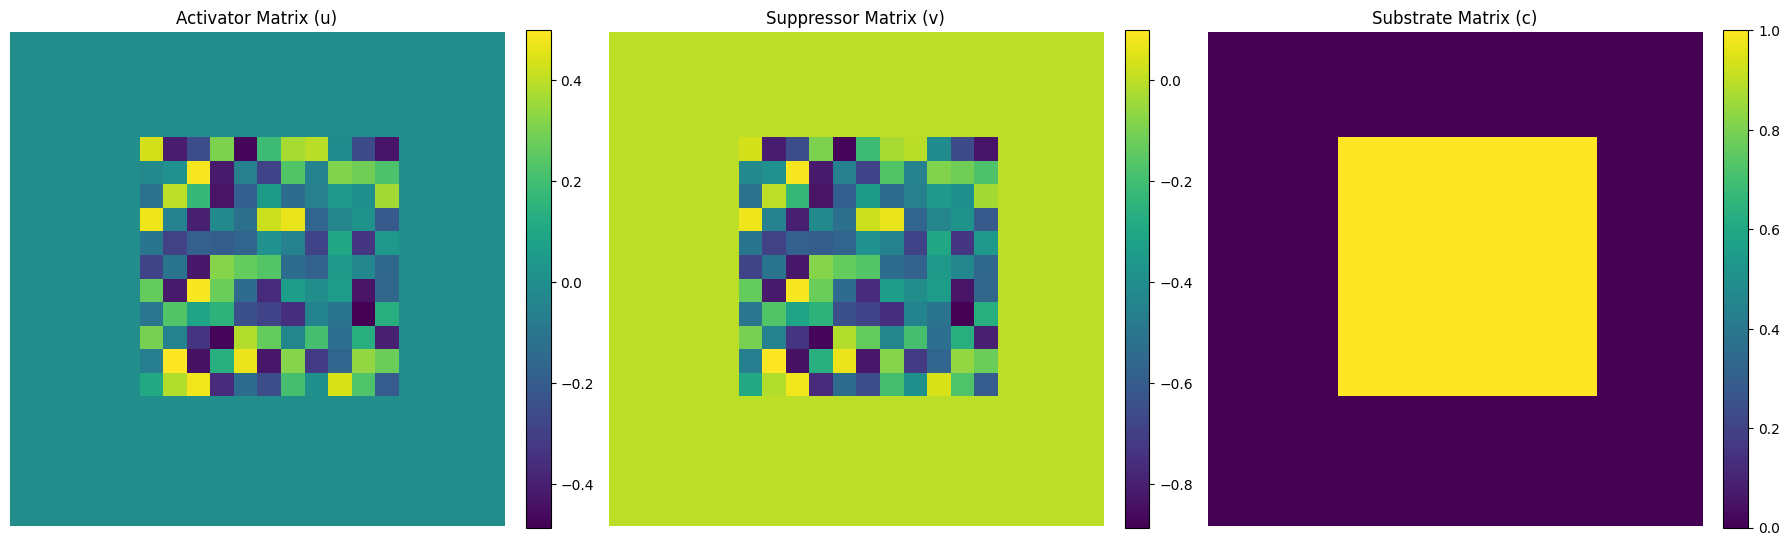

In [18]:
import matplotlib.pyplot as plt

# Assuming 'u', 'v', and 'c' are PyTorch tensors and have been processed appropriately.
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Wider figure to accommodate colorbars

# Define limits for zooming into the center
x_limits = (mid-11, mid+10)
y_limits = (mid-11, mid+10)

# Plot u matrix
im_u = axs[0].imshow(u.cpu().numpy(), cmap='viridis')
axs[0].set_title('Activator Matrix (u)')
axs[0].axis('off')
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
fig.colorbar(im_u, ax=axs[0], fraction=0.046, pad=0.04)  # Add colorbar to the plot of u

# Plot v matrix
im_v = axs[1].imshow(v.cpu().numpy(), cmap='viridis')
axs[1].set_title('Suppressor Matrix (v)')
axs[1].axis('off')
axs[1].set_xlim(x_limits)
axs[1].set_ylim(y_limits)
fig.colorbar(im_v, ax=axs[1], fraction=0.046, pad=0.04)  # Add colorbar to the plot of v

# Plot c matrix
im_c = axs[2].imshow(c.cpu().numpy(), cmap='viridis')
axs[2].set_title('Substrate Matrix (c)')
axs[2].axis('off')
axs[2].set_xlim(x_limits)
axs[2].set_ylim(y_limits)
fig.colorbar(im_c, ax=axs[2], fraction=0.046, pad=0.04)  # Add colorbar to the plot of c

plt.tight_layout()
plt.show()


In [19]:
def update_visualization(step, u, v, c, n):
    fig = plt.figure(figsize=(7, 7))
    
    # Activator u
    ax1 = fig.add_subplot(221)
    img1 = ax1.imshow(u.cpu().numpy(), cmap='jet', vmin=0, vmax=amax)
    ax1.set_title(f'Activator u at iteration {step}')
    fig.colorbar(img1, ax=ax1)  # Add colorbar for this subplot

    # Suppressor v
    ax2 = fig.add_subplot(222)
    img2 = ax2.imshow(v.cpu().numpy(), cmap='jet', vmin=0, vmax=smax)
    ax2.set_title(f'Suppressor v at iteration {step}')
    fig.colorbar(img2, ax=ax2)  # Add colorbar for this subplot

    # Mycelium c
    ax3 = fig.add_subplot(223)
    img3 = ax3.imshow(c.cpu().numpy(), cmap='jet', vmin=-1, vmax=1)
    ax3.set_title(f'Mycelium at iteration {step}')
    fig.colorbar(img3, ax=ax3)  # Add colorbar for this subplot

    # Substrate n
    ax4 = fig.add_subplot(224)
    img4 = ax4.imshow(n.cpu().numpy(), cmap='jet')
    ax4.set_title('Substrate')
    fig.colorbar(img4, ax=ax4)  # Add colorbar for this subplot

    plt.tight_layout()
    plt.show()

In [20]:
# Laplacian (Diffusion) Kernel Weights
lap_side = 0.35
lap_diag = 0.1
lap = 1/9

# Depth (Size) of Kernel
depth = 2

# Plasma Membrane of Mycelium
ij_mat = torch.zeros((grid_size, grid_size), device=device)

In [21]:
# # Pre-calculate the Laplacian kernel indices and weights if they remain constant
# lap_kernel = torch.zeros((2*depth+1, 2*depth+1), device=device)
# for dx in range(-depth, depth + 1):
#     for dy in range(-depth, depth + 1):
#         if dx == 0 and dy == 0:
#             lap_kernel[depth, depth] = lap
#         elif abs(dx) == abs(dy):
#             lap_kernel[depth + dx, depth + dy] = lap_diag
#         else:
#             lap_kernel[depth + dx, depth + dy] = lap_side

# print(lap_kernel)

tensor([[0.1000, 0.3500, 0.3500, 0.3500, 0.1000],
        [0.3500, 0.1000, 0.3500, 0.1000, 0.3500],
        [0.3500, 0.3500, 0.1111, 0.3500, 0.3500],
        [0.3500, 0.1000, 0.3500, 0.1000, 0.3500],
        [0.1000, 0.3500, 0.3500, 0.3500, 0.1000]], device='cuda:0')


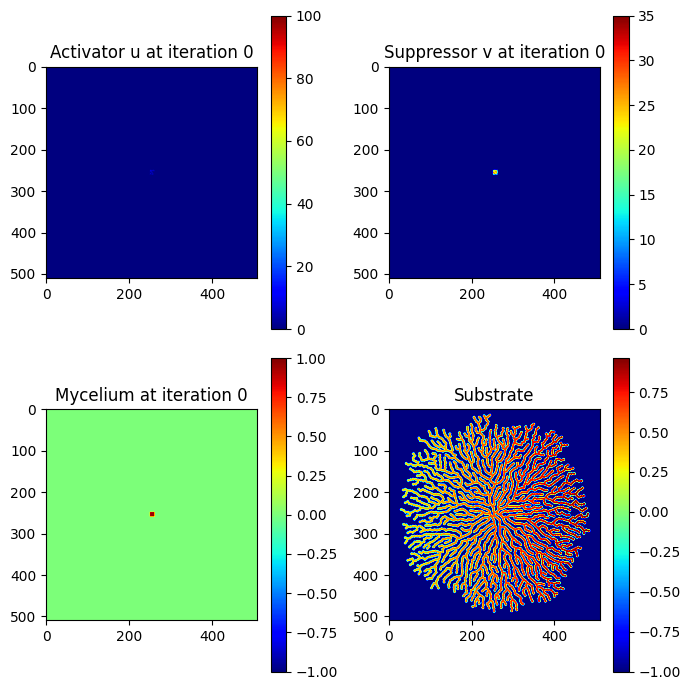

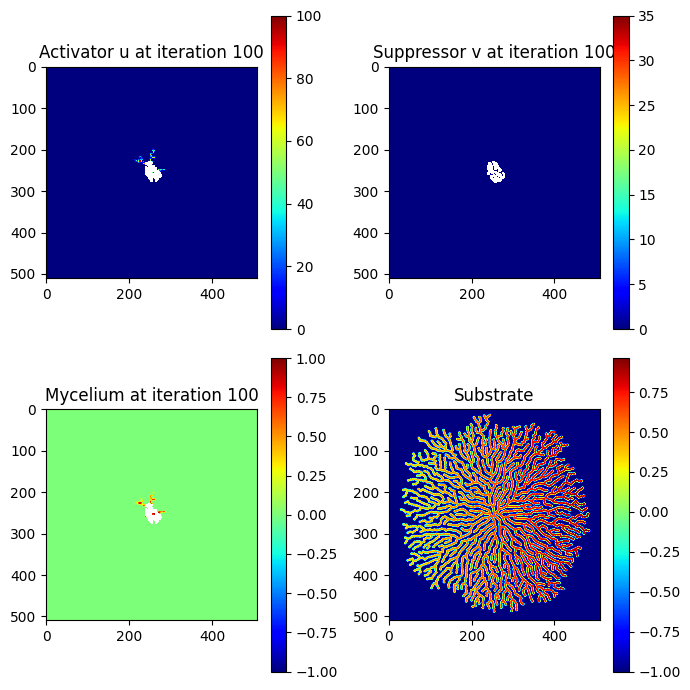

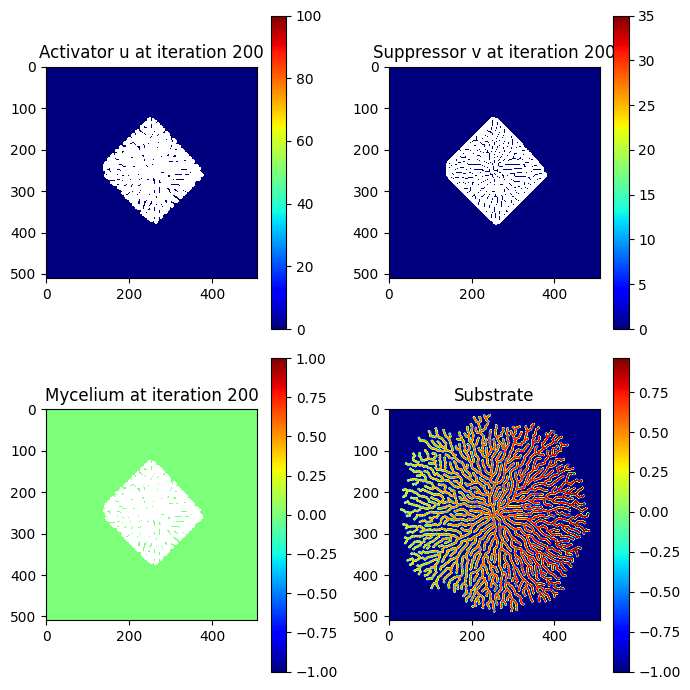

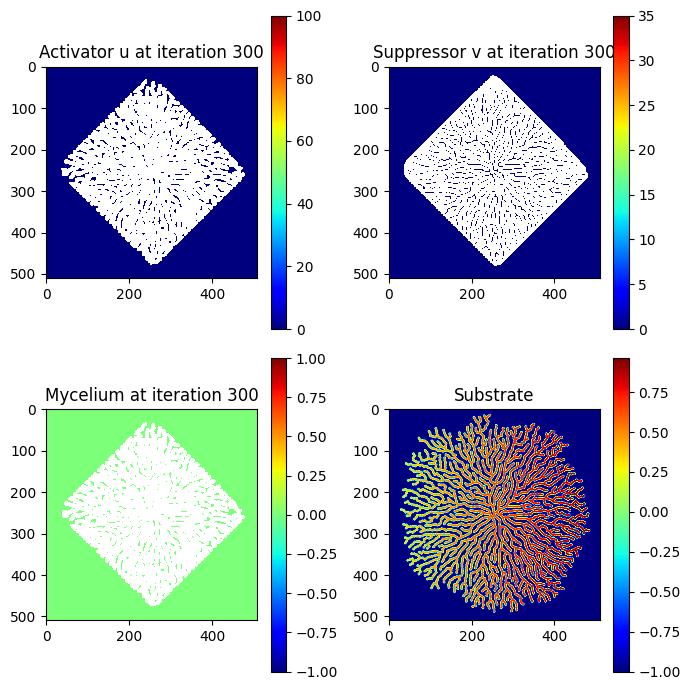

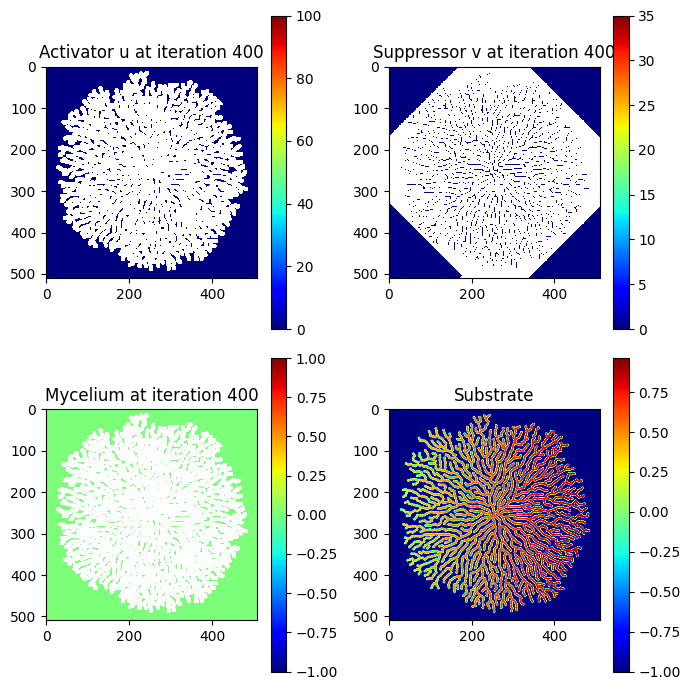

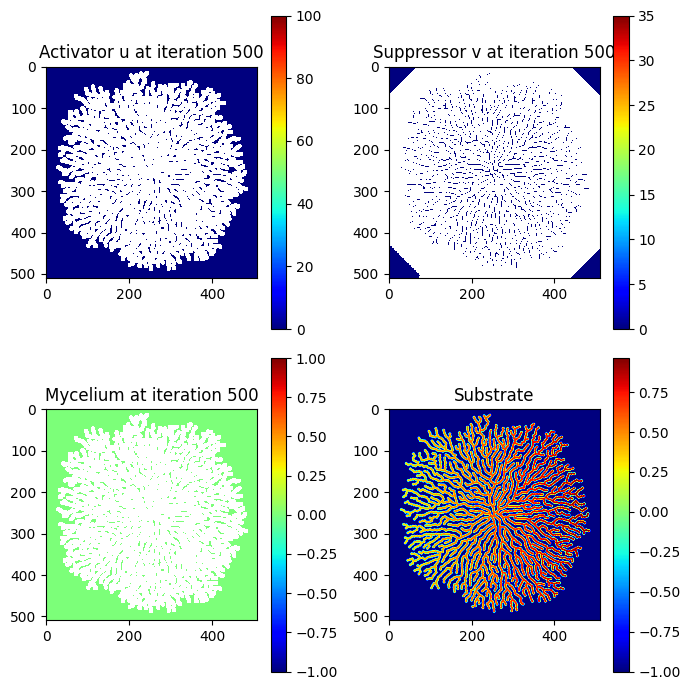

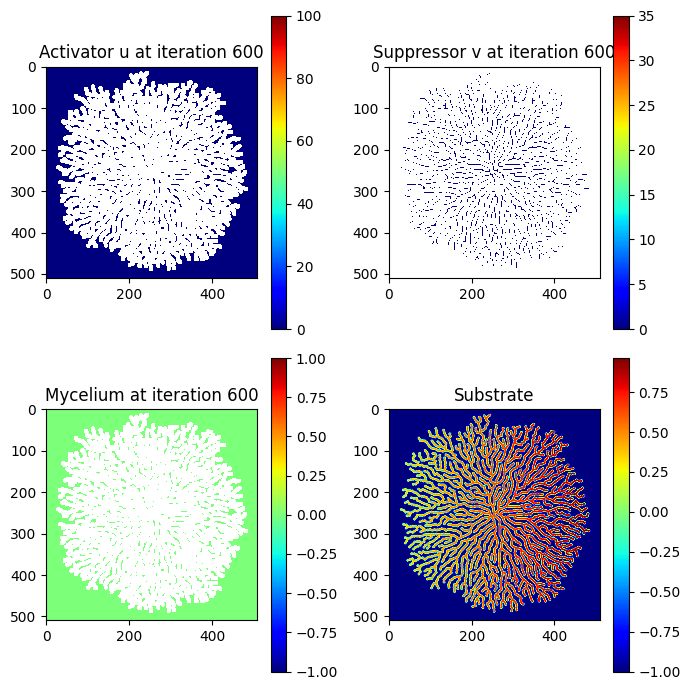

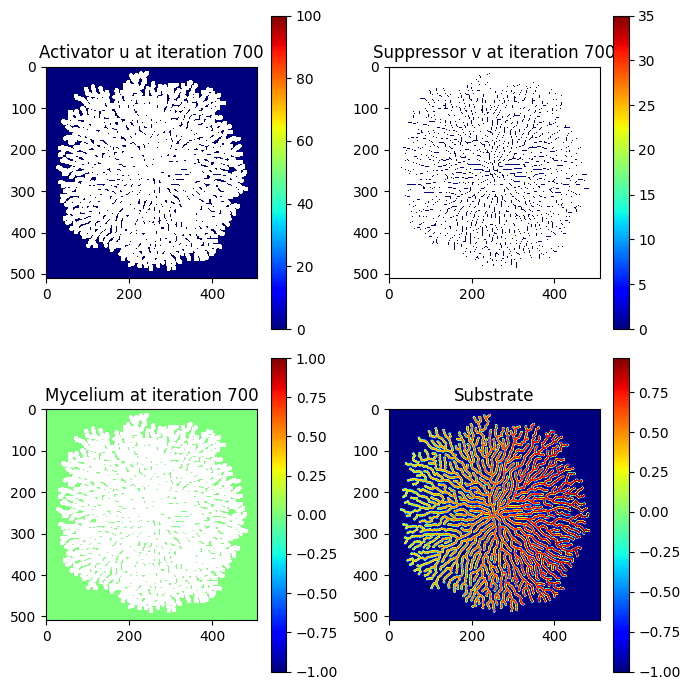

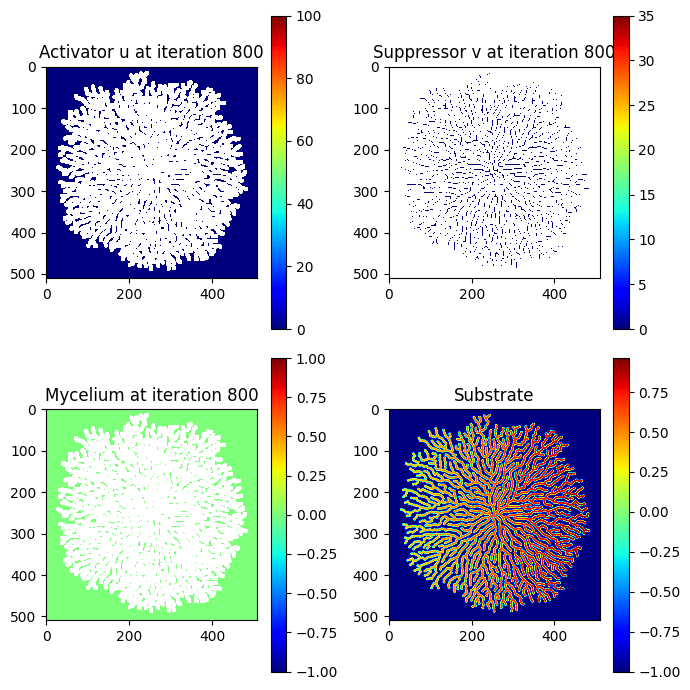

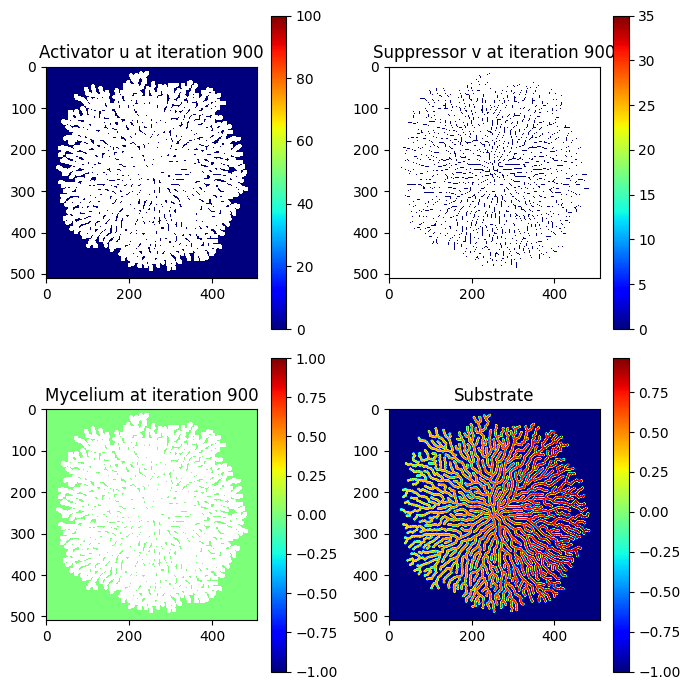

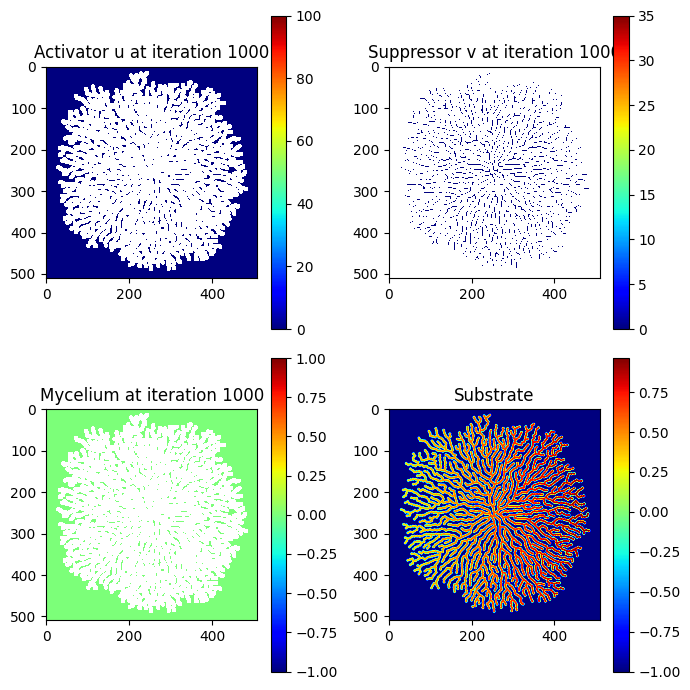

In [22]:
import torch
import torch.nn.functional as F

# Generate a random integer between 1 and 10, and divide by 10000
noise_u = torch.randint(1, 11, u.size(), device=device).float() / 10000
noise_c = torch.randint(1, 1001, c.size(), device=device).float() / 10000
mask = torch.zeros((grid_size, grid_size), device=device)

# Main simulation loop
for step in range(total_iterations + 1):
    # Reaction Terms
    f_uv = (pa * u + u ** 2 - pb * u * v) * n
    g_uv = pe * u ** 3 - v

    # # Calculate ij_mat - the plasma membrane in which the mycelium can expand each iteration
    mask = torch.where(c > 0, torch.ones_like(mask), torch.zeros_like(mask))
    # ij_mat = F.conv2d(ij_mat.unsqueeze(0).unsqueeze(0) * mask.unsqueeze(0).unsqueeze(0), lap_kernel.unsqueeze(0).unsqueeze(0), padding=depth)[0, 0]
    # ij_mat = torch.minimum(F.conv2d(mask.unsqueeze(0).unsqueeze(0), lap_kernel.unsqueeze(0).unsqueeze(0), padding=depth)[0, 0], torch.tensor(1.0, device=device))

    # Pre-calculate the Laplacian kernel indices and weights if they remain constant
    if (c > 0):
        for dx in range(-depth, depth + 1):
            for dy in range(-depth, depth + 1):
                if dx == 0 and dy == 0:
                    ij_mat[depth, depth] = lap
                elif abs(dx) == abs(dy):
                    ij_mat[depth + dx, depth + dy] = lap_diag
                else:
                    ij_mat[depth + dx, depth + dy] = lap_side


    # Update activator and suppressor
    v_new = v + dt * ij_mat * (d * (lap_side * (torch.roll(v, 1, 0) + torch.roll(v, -1, 0) + torch.roll(v, 0, 1) + torch.roll(v, 0, -1)) + 
                                    lap_diag * (torch.roll(v, -1, -1) + torch.roll(v, 1, -1) + torch.roll(v, -1, 1) + torch.roll(v, 1, 1)) - 
                                    lap * v) + gamma * g_uv)
    
    u_new = u + dt * ij_mat * (    (lap_side * (torch.roll(u, 1, 0) + torch.roll(u, -1, 0) + torch.roll(u, 0, 1) + torch.roll(u, 0, -1)) + 
                                    lap_diag * (torch.roll(u, -1, -1) + torch.roll(u, 1, -1) + torch.roll(u, -1, 1) + torch.roll(u, 1, 1)) - 
                                    lap * u) + gamma * f_uv)

    # Apply threshold and adjust alpha
    u_new = torch.where(n == -1, u - noise_u, u_new)
    alpha = torch.where(u <= threshold, 0.49, 0.49 - 2.5 * (u - threshold))
    v_new = torch.where(u <= threshold, v_new, 0)

    # Update c using alpha and apply limits
    c_new = c + dt * gamma * ph * c * (alpha - c) * (c - 1)
    c_new = torch.where(alpha < 0, c + noise_c, c_new)

    # Limiters of activator and suppressor to avoid exponential growth
    u_new = torch.clamp(u_new, min=0, max=amax)
    v_new = torch.where(v_new > smax, smax, v_new)
    c_new = torch.where(c_new > 1, 1, c_new)
    c_new = torch.where(c_new < 0, c + noise_c, c_new)
    c_new = torch.where(c_new == 1, c - noise_c, c_new)
    c_new = torch.where(c_new > 1, 1, c_new)
    
    # Update variables
    u, v, c = u_new, v_new, c_new

    # Visualization every 100 steps
    if step % 100 == 0:
        update_visualization(step, u, v, c, n)